In [1]:
%matplotlib inline
%mpdaf

import matplotlib.pyplot as plt

from astropy.modeling import models, fitting
from muse_analysis.plotutils import show_images_grid

import warnings
warnings.simplefilter('ignore', UserWarning)

from lmfit import minimize, Parameters, fit_report, Minimizer


Numpy 1.15.4
Astropy 3.2.dev23304
MPDAF 3.1.dev2779


/home/simon/.pyenv/versions/3.7.0/lib/python3.7/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


In [2]:
c = Cube('pyastro/star_rebin.fits')
c = c.rebin((5, 1, 1))
c

<Cube(shape=(17, 50, 50), unit='', dtype='float64')>

In [3]:
im = c.mean(axis=0)

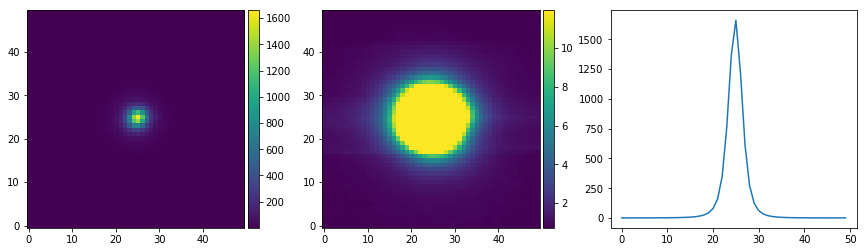

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
im.plot(ax=ax1, colorbar='v')
im.plot(ax=ax2, colorbar='v', zscale=True)
ax3.plot(im.data[im.shape[0]//2]);

## Lmfit

### Gaussian

In [5]:
def elliptical_gaussian(x, y, bckg, amplitude, x_mean, y_mean, x_stddev, y_stddev, theta):
    return bckg + models.Gaussian2D.evaluate(x, y, amplitude, x_mean, y_mean, x_stddev, y_stddev, theta)

In [6]:
def residual(params, xx, yy, data):
    model = elliptical_gaussian(xx, yy, **params)
    res = (data - model)
    return res.ravel()

yy, xx = np.mgrid[:im.shape[0], :im.shape[1]]
x_0, y_0 = np.array(im.shape) / 2
data = im.data.filled(0)

params = Parameters()
params.add('bckg', value=0)
params.add('amplitude', value=data.max())
params.add('x_mean', value=x_0)
params.add('y_mean', value=y_0)
params.add('x_stddev', value=2)
params.add('y_stddev', value=2)
params.add('theta', value=0)

out = minimize(residual, params, args=(xx, yy, data))

In [7]:
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 2500
    # variables        = 7
    chi-square         = 287395.533
    reduced chi-square = 115.281000
    Akaike info crit   = 11875.4217
    Bayesian info crit = 11916.1901
[[Variables]]
    bckg:       3.59045270 +/- 0.21774985 (6.06%) (init = 0)
    amplitude:  1500.51354 +/- 5.18228576 (0.35%) (init = 1659.26)
    x_mean:     24.8289151 +/- 0.00584994 (0.02%) (init = 25)
    y_mean:     24.7565853 +/- 0.00557840 (0.02%) (init = 25)
    x_stddev:   1.70975286 +/- 0.00592583 (0.35%) (init = 2)
    y_stddev:   1.59828505 +/- 0.00553952 (0.35%) (init = 2)
    theta:      0.39377318 +/- 0.03619885 (9.19%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, x_stddev) = -0.498
    C(amplitude, y_stddev) = -0.498


In [8]:
# see https://github.com/PaulHancock/Aegean/blob/master/AegeanTools/fitting.py
# result = lmfit.minimize(residual, params, kws={'x': mask[0], 'y': mask[1], 'B': B, 'errs': errs}, Dfun=lmfit_jacobian)

### Moffat

In [9]:
def moffat(x, y, bckg, amplitude, x_0, y_0, gamma, alpha):
    return bckg + models.Moffat2D.evaluate(x, y, amplitude, x_0, y_0, gamma, alpha)

In [11]:
def residual(params, xx, yy, data):
    model = moffat(xx, yy, **params.valuesdict())
    res = (data - model)
    return res.ravel()

In [42]:
yy, xx = np.mgrid[:im.shape[0], :im.shape[1]]
x_0, y_0 = np.array(im.shape) / 2
data = im.data.filled(0)

params = Parameters()
params.add('bckg', value=1)
params.add('amplitude', value=data.max())
params.add('x_0', value=x_0)
params.add('y_0', value=y_0)
params.add('gamma', value=3)
params.add('alpha', value=2.5)

out = minimize(residual, params, args=(xx, yy, data))

In [43]:
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 2500
    # variables        = 6
    chi-square         = 30443.5551
    reduced chi-square = 12.2067182
    Akaike info crit   = 6260.95896
    Bayesian info crit = 6295.90324
[[Variables]]
    bckg:       0.97231657 +/- 0.07699666 (7.92%) (init = 1)
    amplitude:  1701.52611 +/- 2.55448881 (0.15%) (init = 1659.26)
    x_0:        24.8342988 +/- 0.00181104 (0.01%) (init = 25)
    y_0:        24.7629224 +/- 0.00181057 (0.01%) (init = 25)
    gamma:      2.76389693 +/- 0.01293837 (0.47%) (init = 3)
    alpha:      2.26009996 +/- 0.01339051 (0.59%) (init = 2.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha)     =  0.977
    C(amplitude, gamma) = -0.669
    C(amplitude, alpha) = -0.542
    C(bckg, alpha)      =  0.360
    C(bckg, gamma)      =  0.315
    C(bckg, amplitude)  = -0.155


In [44]:
out.params.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
alpha          2.26     -inf      inf  0.01339     True     None     None
amplitude      1702     -inf      inf    2.554     True     None     None
bckg         0.9723     -inf      inf    0.077     True     None     None
gamma         2.764     -inf      inf  0.01294     True     None     None
x_0           24.83     -inf      inf 0.001811     True     None     None
y_0           24.76     -inf      inf 0.001811     True     None     None


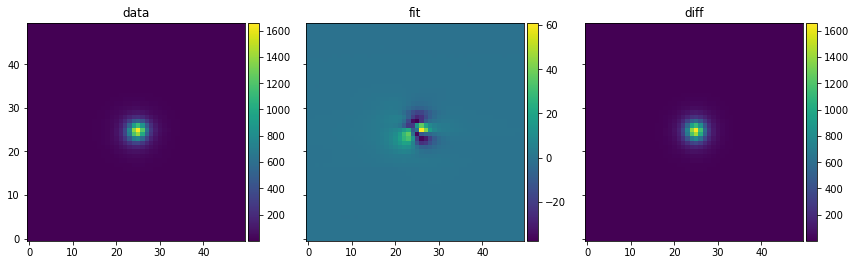

In [45]:
res = out.residual.reshape(data.shape)
show_images_grid([data, res, data - res], figsize=(4, 4), titles=('data', 'fit', 'diff'));

In [46]:
def moffat_deriv(x, y, bckg, amplitude, x_0, y_0, gamma, alpha):
    return [np.ones_like(x)] + models.Moffat2D.fit_deriv(x, y, amplitude, x_0, y_0, gamma, alpha)

In [47]:
def dfunc(params, xx, yy, data):
    return np.array([x.ravel() for x in moffat_deriv(xx, yy, **params.valuesdict())]).T

In [48]:
out = minimize(residual, params, args=(xx, yy, data), Dfun=dfunc)

In [49]:
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 2500
    # variables        = 6
    chi-square         = 338171.890
    reduced chi-square = 135.594182
    Akaike info crit   = 12280.1590
    Bayesian info crit = 12315.1032
[[Variables]]
    bckg:       0.99999251 +/- 0.25265938 (25.27%) (init = 1)
    amplitude:  1659.26050 +/- 8.24866850 (0.50%) (init = 1659.26)
    x_0:        25.0000030 +/- 0.00613566 (0.02%) (init = 25)
    y_0:        25.0000045 +/- 0.00613566 (0.02%) (init = 25)
    gamma:      2.99999996 +/- 0.05037909 (1.68%) (init = 3)
    alpha:      2.50000016 +/- 0.05560205 (2.22%) (init = 2.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha)     =  0.981
    C(amplitude, gamma) = -0.659
    C(amplitude, alpha) = -0.543
    C(bckg, alpha)      =  0.325
    C(bckg, gamma)      =  0.287
    C(bckg, amplitude)  = -0.141


In [32]:
params = Parameters()
params.add('bckg', value=0)
params.add('amplitude', value=data.max())
params.add('x_0', value=x_0)
params.add('y_0', value=y_0)
params.add('gamma', value=3)
params.add('alpha', value=2.5)

out = minimize(residual, params, args=(xx, yy, data), method='least_squares')

In [33]:
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 7
    # data points      = 2500
    # variables        = 6
    chi-square         = 30443.5551
    reduced chi-square = 12.2067182
    Akaike info crit   = 6260.95896
    Bayesian info crit = 6295.90324
[[Variables]]
    bckg:       0.97232219 (init = 0)
    amplitude:  1701.52565 (init = 1659.26)
    x_0:        24.8342990 (init = 25)
    y_0:        24.7629226 (init = 25)
    gamma:      2.76390017 (init = 3)
    alpha:      2.26010316 (init = 2.5)


In [35]:
out.params.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
alpha          2.26     -inf      inf     None     True     None     None
amplitude      1702     -inf      inf     None     True     None     None
bckg         0.9723     -inf      inf     None     True     None     None
gamma         2.764     -inf      inf     None     True     None     None
x_0           24.83     -inf      inf     None     True     None     None
y_0           24.76     -inf      inf     None     True     None     None


In [42]:
out.params.pretty_print(oneline=True)

Parameters([('bckg', <Parameter 'bckg', value=0.9723164992953979 +/- 0.077, bounds=[-inf:inf]>), ('amplitude', <Parameter 'amplitude', value=1701.5261152359303 +/- 2.55, bounds=[-inf:inf]>), ('x_0', <Parameter 'x_0', value=24.834298823007185 +/- 0.00181, bounds=[-inf:inf]>), ('y_0', <Parameter 'y_0', value=24.76292241528351 +/- 0.00181, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=2.763896896958709 +/- 0.0129, bounds=[-inf:inf]>), ('alpha', <Parameter 'alpha', value=2.260099918753076 +/- 0.0134, bounds=[-inf:inf]>)])


In [49]:
out.params.add('noise', value=1, min=0.001, max=2)

def lnprob(p, xx, yy, data):
    noise = p['noise']
    params = p.copy()
    params.pop('noise')
    return -0.5 * np.sum((residual(params, xx, yy, data) / noise)**2 + np.log(2 * np.pi * noise**2))

mini = Minimizer(lnprob, out.params, fcn_args=(xx, yy, data))
res = mini.emcee(burn=300, steps=1000, thin=20, params=out.params)


In [51]:
res.params.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
alpha          2.26     -inf      inf 0.007779     True     None     None
amplitude      1702     -inf      inf    1.541     True     None     None
bckg         0.9748     -inf      inf  0.04303     True     None     None
gamma         2.764     -inf      inf 0.007585     True     None     None
noise             2    0.001        2 0.0004667     True     None     None
x_0           24.83     -inf      inf 0.001098     True     None     None
y_0           24.76     -inf      inf 0.001147     True     None     None


In [52]:
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 2500
    # variables        = 6
    chi-square         = 30443.5551
    reduced chi-square = 12.2067182
    Akaike info crit   = 6260.95896
    Bayesian info crit = 6295.90324
[[Variables]]
    bckg:       0.97231650 +/- 0.07699666 (7.92%) (init = 0)
    amplitude:  1701.52612 +/- 2.55448882 (0.15%) (init = 1659.26)
    x_0:        24.8342988 +/- 0.00181104 (0.01%) (init = 25)
    y_0:        24.7629224 +/- 0.00181057 (0.01%) (init = 25)
    gamma:      2.76389690 +/- 0.01293837 (0.47%) (init = 3)
    alpha:      2.26009992 +/- 0.01339051 (0.59%) (init = 2.5)
    noise:      1.00000000 (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha)     =  0.977
    C(amplitude, gamma) = -0.669
    C(amplitude, alpha) = -0.542
    C(bckg, alpha)      =  0.360
    C(bckg, gamma)      =  0.315
    C(bckg, amplitude)  = -0.155


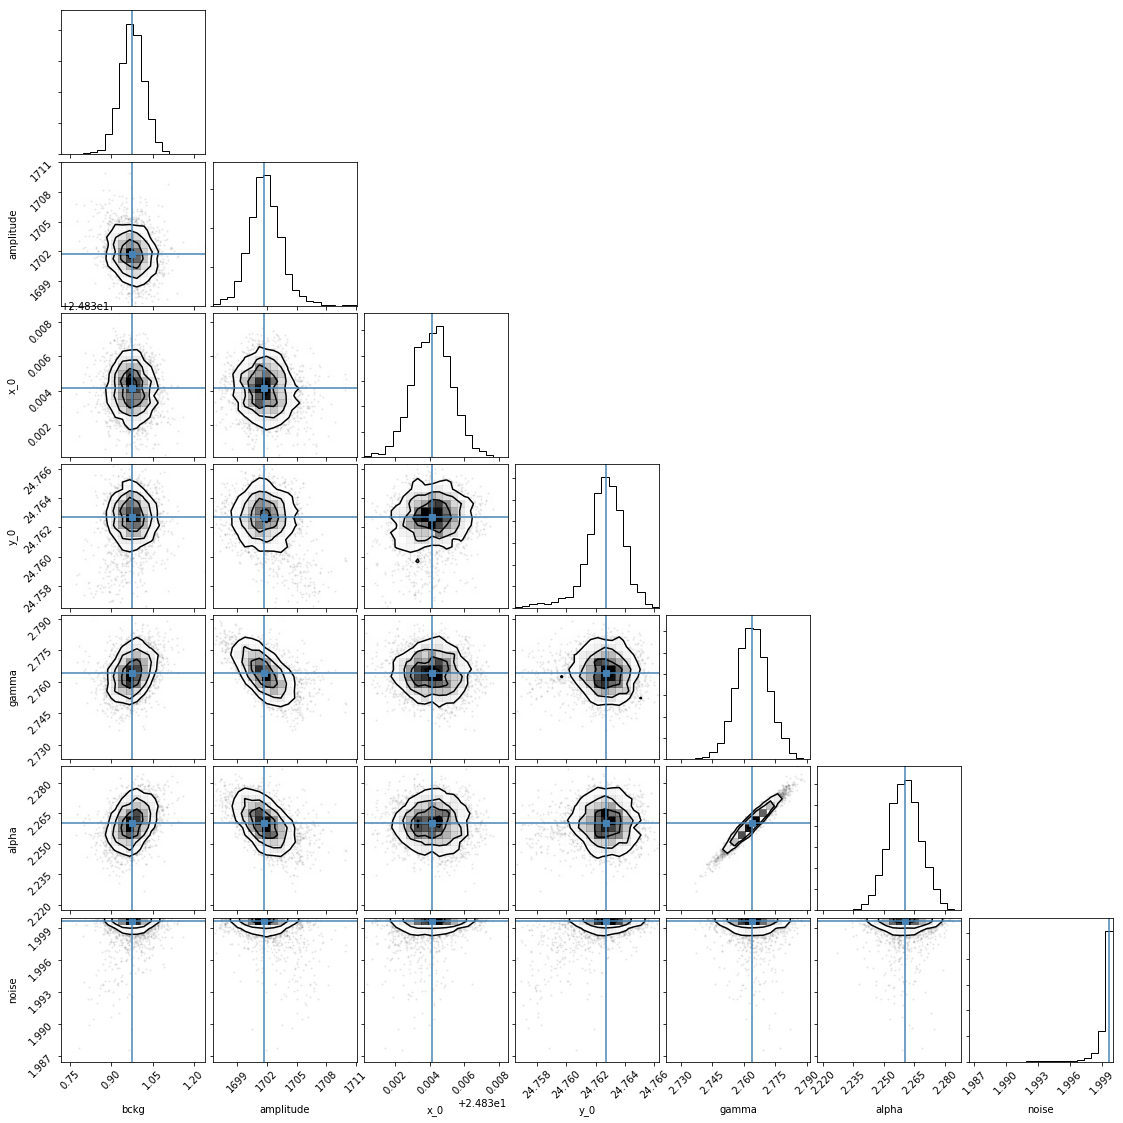

In [54]:
import corner
corner.corner(res.flatchain, labels=res.var_names, truths=list(res.params.valuesdict().values()));

## Astropy

In [9]:
yy, xx = np.mgrid[:im.shape[0], :im.shape[1]]
x_0, y_0 = np.array(im.shape) / 2

data = im.data.filled(0)

model = models.Const2D(amplitude=0) + models.Moffat2D(amplitude=data.max(), x_0=x_0-5, y_0=y_0-5, gamma=3, alpha=2.5)
model

<CompoundModel1(amplitude_0=0., amplitude_1=1659.26047148, x_0_1=20., y_0_1=20., gamma_1=3., alpha_1=2.5)>

In [10]:
fitter = fitting.LevMarLSQFitter()
fit = fitter(model, xx, yy, data, maxiter=500)
fit

<CompoundModel1(amplitude_0=0.97220129, amplitude_1=1701.52500702, x_0_1=24.83433698, y_0_1=24.76289113, gamma_1=2.76386914, alpha_1=2.26006096)>

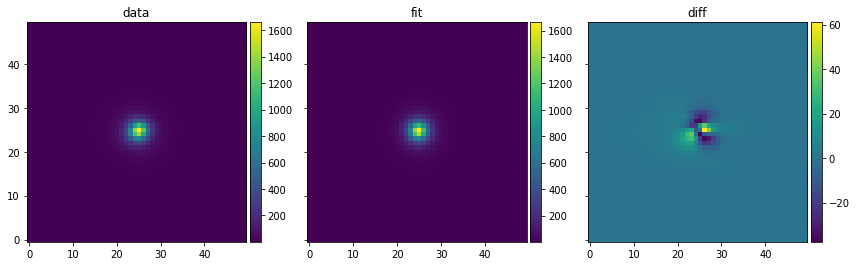

In [11]:
show_images_grid([data, fit(xx, yy), data - fit(xx, yy)], figsize=(4, 4), titles=('data', 'fit', 'diff'));

In [12]:
fitter.fit_info

{'nfev': 139,
 'fvec': array([0.24128645, 0.18447992, 0.19419628, ..., 0.38499861, 0.41609448,
        0.3901885 ]),
 'fjac': array([[-2.05733006e+03,  1.49328962e-05,  1.63430847e-05, ...,
          1.82975012e-05,  1.66874729e-05,  1.52157843e-05],
        [ 1.36853599e+00,  1.92968331e+03,  1.03906710e-06, ...,
         -1.22431957e-06, -1.07202891e-06, -9.38418426e-07],
        [ 1.17912396e+00,  6.70094513e-03,  1.92918036e+03, ...,
         -1.11925591e-06, -1.02377394e-06, -9.34429645e-07],
        [ 1.75413908e+03, -6.75901951e-01, -5.98849097e-01, ...,
          2.51405248e-04,  2.31815373e-04,  2.13686933e-04],
        [-1.13221530e+01,  7.99196504e-03,  6.84612376e-03, ...,
          2.16740103e-02,  2.16817706e-02,  2.16889472e-02],
        [-2.03976679e+00,  2.74253574e-04, -5.79866316e-06, ...,
          3.18251321e-03,  3.19450182e-03,  3.20561225e-03]]),
 'ipvt': array([5, 4, 3, 6, 1, 2], dtype=int32),
 'qtf': array([-0.00824287,  0.00353845, -0.00111623, -0.01064557,  